In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [3]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class SocialAgent(Agent):
    def __init__(self, unique_id, model, initial_wealth, norm): # Norm = 0  or 1 corresponding to selfish or altruistic behavior
        super().__init__(unique_id, model)
        self.norm = norm
        self.wealth = initial_wealth
        self.employed = random.random() < self.model.employment_rate  # 80% chance of being employed initially

    def step(self):
        self.generate_wealth()
        self.expenditure()
        self.trade()
        self.redistribute_wealth()
        self.social_influence()


    def generate_wealth(self):
        # Proportional wealth increase.
        self.wealth *= 1 + self.model.growth_rate

        # Compute the salary based on the percentage of wealth
        proportional_salary = self.model.salary * self.wealth 

        # Fixed wealth increase which emulates a salary from a job. # This should depend on employment status.
        self.wealth += proportional_salary #self.model.salary

    def generate_wealth(self):
        self.wealth *= 1 + self.model.growth_rate
        if self.employed:
            proportional_salary = self.model.salary * self.wealth 
            self.wealth += proportional_salary
        
        if not self.employed:
            if self.random.random() < self.model.job_search_probability:
                self.employed = True
        elif self.random.random() < self.model.layoff_probability:
                self.employed = False


    def expenditure(self):
        
        random_expenditure = self.random.uniform(self.model.min_expenditure, self.model.max_expenditure)

        if self.wealth >=0:

            self.wealth -= random_expenditure 
    


    def trade(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        if self.wealth > 0:
            neighbor = self.random.choice(neighbors)
            trade_amount = self.model.trade_ratio * self.wealth
            self.wealth -= trade_amount
            neighbor.wealth += trade_amount

    def check_sufficiency(self):
        # If wealth is below sufficiency threshold, change to selfish
        if self.wealth < self.model.sufficiency_threshold:
            self.norm = 0 # selfish

    def redistribute_wealth(self):

        # Collect donations from altruistic agents
        if self.norm == 1 and self.wealth > 0:
            donation = self.model.donation_ratio * self.wealth
            self.wealth -= donation
            self.model.donation_pool += donation

        
        # Calculate the total amount needed by all agents below the sufficiency threshold
        total_needed = 0
        agents_below_threshold = []
        for agent in self.model.schedule.agents:
            if agent.wealth < self.model.sufficiency_threshold:
                needed = self.model.sufficiency_threshold - agent.wealth
                total_needed += needed
                agents_below_threshold.append((agent, needed))

        # Distribute the donation pool proportionally to all agents below the sufficiency threshold
        if total_needed > 0:
            for agent, needed in agents_below_threshold:
                proportion = needed / total_needed
                donation = proportion * self.model.donation_pool
                agent.wealth += donation

                # Update the norm of the agent if the agent is selfish
                if agent.norm == 0:
                    if random.random() < self.model.norm_change_probability:
                        agent.norm = 1

            # Reset the donation pool after redistribution
            self.model.donation_pool = 0
        ############################    

    
    def social_influence(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        norm_counts = {0: 0, 1: 0}
        for neighbor in neighbors:
            norm_counts[neighbor.norm] += 1
        
        majority_norm = max(norm_counts, key=norm_counts.get)
        
        if norm_counts[majority_norm] > len(neighbors) / 2:
            # Check if the probability of norm_change
            # Print the norm_counts and len of neighbours
            # print(norm_counts[majority_norm], len(neighbors))

            if random.random() < self.model.norm_change_probability:
                self.norm = majority_norm


class SocialNormModel(Model):
    def __init__(
            self, 
            num_agents, 
            avg_node_degree, 
            rewiring_prob, 
            initial_wealth, 
            growth_rate, 
            trade_ratio, 
            salary, 

            max_expenditure,
            min_expenditure, 
            donation_ratio, 
            ratio_of_altruistic_agents,
            sufficiency_threshold,
            wealth_distribution="equal",
            employment_rate=0.8,
            job_search_probability=0.05,
            layoff_probability=0.02,
            norm_change_probability=0.60,
            network_type="barabasi_albert",
            

                 ):
        
        self.num_agents = num_agents
        self.growth_rate = growth_rate
        self.trade_ratio = trade_ratio
        self.salary = salary
        self.max_expenditure = max_expenditure
        self.min_expenditure = min_expenditure
        self.donation_ratio = donation_ratio
        self.wealth_distribution = wealth_distribution
        self.sufficiency_threshold = sufficiency_threshold
        self.employment_rate = employment_rate
        self.job_search_probability = job_search_probability
        self.layoff_probability = layoff_probability
        self.norm_change_probability = norm_change_probability
        self.donation_pool = 0
        self.network_type = network_type

        # Create network
        if self.network_type == "barabasi_albert":
            self.G = nx.barabasi_albert_graph(n=num_agents, m=avg_node_degree)
        elif self.network_type == "erdos_renyi":
            self.G = nx.erdos_renyi_graph(n=num_agents, p=rewiring_prob)

        # Barbasi-Albert
        # self.G = nx.barabasi_albert_graph(n=num_agents, m=avg_node_degree)
        # try a different network that simulates an economic network
        # self.G = nx.erdos_renyi_graph(n=num_agents, p=rewiring_prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)

        # Generate initial wealth distribution
        initial_wealths = self.generate_initial_wealth(initial_wealth)

        # Shuffle the initial_wealths list
        random.shuffle(initial_wealths)

        # # Print initial wealth
        # print(initial_wealths)

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            # Determine if the agent is altruistic based on the given ratio
            if random.random() < ratio_of_altruistic_agents:
                norm = 1
            else:
                norm = 0

            agent = SocialAgent(unique_id=i, model=self, initial_wealth=initial_wealths[i], norm=norm)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        # Data collector (optional)
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini, "donation_pool": "donation_pool"},
            agent_reporters={"Wealth": "wealth", "Norm": "norm"}

        )

    def generate_initial_wealth(self, initial_wealth):
        # Equal distribution
        if self.wealth_distribution == "equal":
            return [initial_wealth] * self.num_agents

        # Unequal distribution
        elif self.wealth_distribution == "unequal":
            return sorted([random.expovariate(1) * initial_wealth for _ in range(self.num_agents)], reverse=True)

        # Very Unequal distribution
        elif self.wealth_distribution == "very_unequal":
            return sorted([random.paretovariate(1.5) * initial_wealth for _ in range(self.num_agents)], reverse=True)
        
        # Normal distribution
        elif self.wealth_distribution == "normal": 
            return [random.normalvariate(0, 1) * initial_wealth for _ in range(self.num_agents)]

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def run_model(self, n):
        for _ in range(n):
            self.step()



/var/folders/2k/gl2zft0n43b646yzs175ky_m0000gn/T/ipykernel_8935/3359971971.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


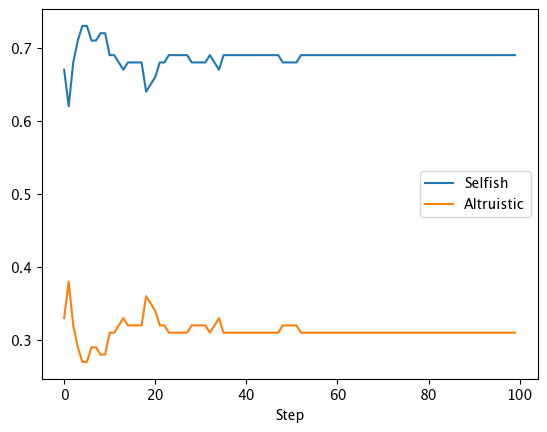

In [4]:
# Running Script

seed = 420
random.seed(seed)
np.random.seed(seed)

# Normal Single Run 

model = SocialNormModel(
            num_agents = 100, 
            avg_node_degree=2, 
            rewiring_prob=0.09, 
            initial_wealth = 150, 
            growth_rate = 0.01, #0.001, 
            trade_ratio = 0.05, #0.05, 
            salary = 0.1, #0.1, 
            max_expenditure = 15,
            min_expenditure=5,
            donation_ratio = 0.05, #not sensitive
            ratio_of_altruistic_agents=0.3,
            sufficiency_threshold = 6,
            wealth_distribution="unequal",
            norm_change_probability=0.74,
            network_type="barabasi_albert",
    
)

# Run the model
timesteps = 100
model.run_model(timesteps)

# Get the data
data = model.datacollector.get_agent_vars_dataframe()
gini = model.datacollector.get_model_vars_dataframe()["Gini"]

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()

# Change legend labels 
plt.legend(["Selfish", "Altruistic"])
plt.show()

In [ ]:
# Visualization Script
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd
import matplotlib.patches as mpatches

# Sample data simulation for demonstration purposes.
# Replace this with your actual data.


# Function to update all subplots
def update_all(i):
    
    norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
    # Filter data for the current step
    current_step_data = data[data['Step'] == i].set_index('AgentID')

    for node in model.G.nodes():
        if node in current_step_data.index:
            norm_value = current_step_data.loc[node, 'Norm']
            model.G.nodes[node]['color'] = '#7CCD7C' if norm_value == 1 else '#FF69B4'
        else:
            model.G.nodes[node]['color'] = 'gray'  # Default color if there's no data for the node
    
    node_colors = [model.G.nodes[n]['color'] for n in model.G.nodes()]
    
    # Clear the axis and draw the graph
    ax1.cla()
    ax1.axis('off')
    ax1.set_title(f'ER network: step {i} with ratio of altruistic agents 0.47')
    nx.draw(model.G, pos, node_color=node_colors, with_labels=False, 
            node_size=50, 
            width=0.3, 
            alpha=0.8, 
            ax=ax1,)
    selfish_patch = mpatches.Patch(color='#FF69B4', label='Selfish')
    altruistic_patch = mpatches.Patch(color='#7CCD7C', label='Altruistic')
    ax1.legend(handles=[selfish_patch, altruistic_patch], loc='lower right')
    
    # Update Norm Percentage Plot
    ax2.cla()
    ax2.plot(norm_counts.index[:i+1], norm_counts[1][:i+1], label='Altruistic', color='#7CCD7C')
    ax2.plot(norm_counts.index[:i+1], norm_counts[0][:i+1], label='Selfish', color='#FF69B4')
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, timesteps)
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Percentage')
    ax2.set_title('Percentage by Norm Over Time')
    ax2.legend(loc='upper right')
    
    # pool
    ax3.clear()
    ax3.plot(donation_pool.index[:i+1], donation_pool[:i+1], label='Donation Pool', color='#7B68EE')
    ax3.set_xlim(0, len(donation_pool))
    ax3.set_ylim(0, donation_pool.max() * 1.1)  # Add some space above the max value for better visualization
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Donation Pool')
    ax3.set_title('Donation Pool Over Time')
    ax3.legend(loc='upper right')
    
    # Update Gini Coefficient Plot
    ax4.cla()
    ax4.plot(gini.index[:i+1], gini[:i+1], label='Gini Coefficient', color='#5CACEE')
    ax4.set_ylim(0, 1)
    ax4.set_xlim(0, timesteps)
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Gini Coefficient')
    ax4.set_title('Gini Coefficient Over Time')
    ax4.legend(loc='upper right')
    

# Create a figure with three columns of subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, dpi=150, figsize=(25, 5))


# Create the combined animation
fps = 10  # Frames per second
ani = animation.FuncAnimation(fig, update_all, frames=timesteps, interval=1000/fps)

# Save the animation as a gif
ani.save('combined_animation_equal_no_transition.gif', writer='pillow', fps=fps)

# Display the final plot
plt.show()